In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Nécessaire pour le plot 3D avec matplotlib
from torch_geometric.datasets import ModelNet
import torch_geometric.transforms as T


In [2]:
transform = T.NormalizeScale()
dataset = ModelNet(root='./data/ModelNet40', name='40', transform=transform)
print(f"Dataset loaded: {len(dataset)} objets")

Dataset loaded: 9843 objets


In [9]:
if hasattr(dataset, 'classes'):
    class_names = dataset.classes
else:
    class_names = [str(i) for i in range(40)]


In [10]:
class_number = 16
num_points = -1


Nombre de points utilisés : 732
Classe sélectionnée : 16 - 16


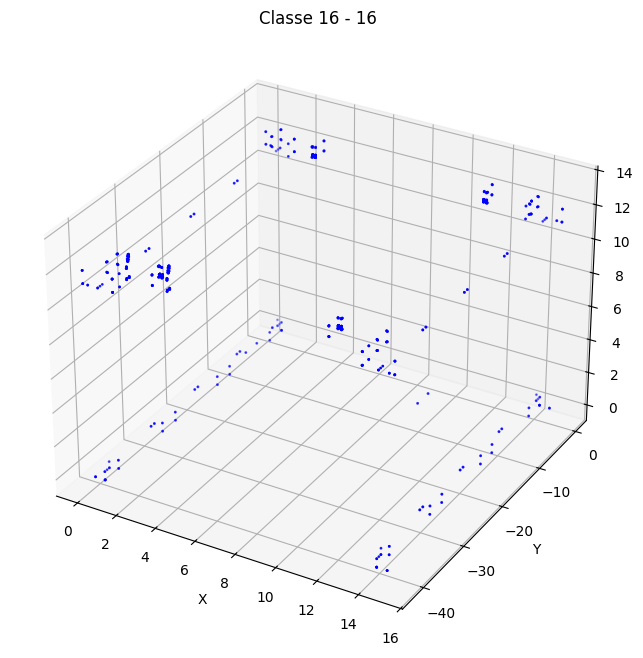

In [13]:

# Recherche d'un échantillon correspondant à la classe choisie
selected_sample = None

for data in dataset:
    if int(data.y) == class_number:
        selected_sample = data
        

if selected_sample is None:
    print(f"Aucun échantillon trouvé pour la classe {class_number}.")
else:
    # Récupération du nuage de points (data.pos est un tensor de forme [N, 3])
    points = selected_sample.pos.numpy()  # Conversion en numpy pour le traitement
    
    # Si num_points est différent de -1, on sous-échantillonne aléatoirement
    if num_points != -1:
        if num_points > points.shape[0]:
            print(f"L'objet ne contient que {points.shape[0]} points. Utilisation de tous les points.")
        else:
            indices = np.random.choice(points.shape[0], num_points, replace=False)
            points = points[indices]
    
    # Affichage du nombre de points utilisés
    print(f"Nombre de points utilisés : {points.shape[0]}")
    if class_number < len(class_names):
        print(f"Classe sélectionnée : {class_number} - {class_names[class_number]}")
    else:
        print(f"Classe sélectionnée : {class_number}")

    # Affichage du nuage de points en 3D avec matplotlib
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='b')
    ax.set_title(f"Classe {class_number} - {class_names[class_number] if class_number < len(class_names) else 'Unknown'}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

Dataset loaded with 9843 objects.


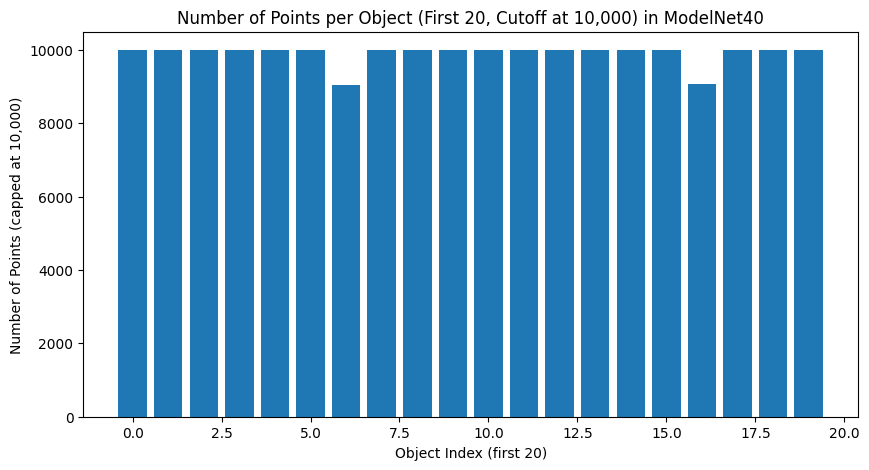

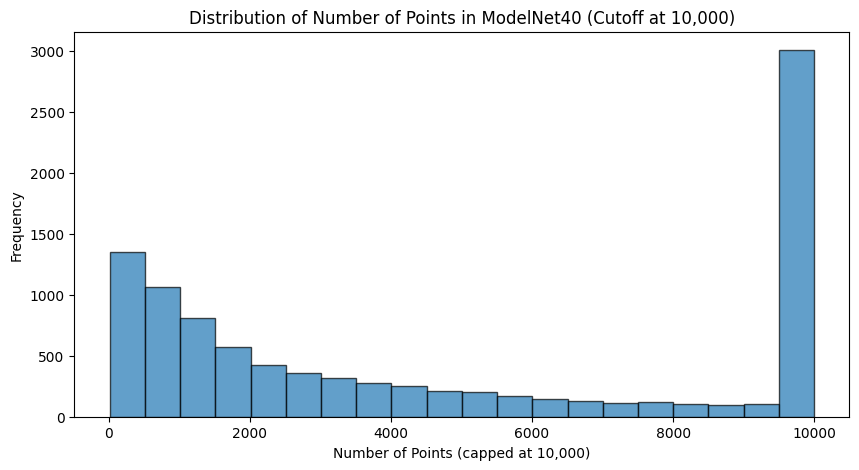

In [26]:
#%% [code]
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import ModelNet
import torch_geometric.transforms as T

# Use only normalization so that the original number of points is preserved.
transform = T.Compose([T.NormalizeScale()])

# Load ModelNet40 dataset (without SamplePoints to keep original point counts)
dataset = ModelNet(root='./data/ModelNet40', name='40', transform=transform)
print(f"Dataset loaded with {len(dataset)} objects.")

# Compute the number of points per object with a cutoff at 10,000 points
num_points_list = []
cutoff = 10000
for i in range(len(dataset)):
    data = dataset[i]
    # data.pos is a tensor of shape [N, 3]
    n_points = data.pos.size(0)
    # Apply the cutoff: if more than cutoff, cap at cutoff.
    n_points = min(n_points, cutoff)
    num_points_list.append(n_points)

num_points_array = np.array(num_points_list)

# ----- Plot a bar chart for a subset (e.g., first 20 objects) -----
plt.figure(figsize=(10, 5))
plt.bar(np.arange(20), num_points_array[:20])
plt.xlabel("Object Index (first 20)")
plt.ylabel("Number of Points (capped at 10,000)")
plt.title("Number of Points per Object (First 20, Cutoff at 10,000) in ModelNet40")
plt.show()

# ----- Plot a histogram of the distribution of points (with the cutoff) -----
plt.figure(figsize=(10, 5))
plt.hist(num_points_array, bins=20, edgecolor='k', alpha=0.7)
plt.xlabel("Number of Points (capped at 10,000)")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Points in ModelNet40 (Cutoff at 10,000)")
plt.show()


---

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.datasets import ModelNet
import torch_geometric.transforms as T


In [2]:
dataset = ModelNet(root='./data/ModelNet40', name='40', train=True, transform=None)
print(f"Total objects in train split: {len(dataset)}")


Total objects in train split: 9843


In [3]:
# %%
# 3) Iterate and build DataFrame
records = []
for idx, data in enumerate(dataset):
    # data.pos is a [N,3] FloatTensor of XYZ coords
    pts = data.pos.numpy()  
    label = int(data.y)     # class index
    n_pts = pts.shape[0]
    records.append({
        'index': idx,
        'num_points': n_pts,
        'label': label,
        'points': pts,        # stored as array in object column
    })

df = pd.DataFrame(records)
print("DataFrame constructed:")
df.head()


DataFrame constructed:


,index,num_points,label,points
0,0,90714,0,"[[20.967, -26.1154, 46.5444], [21.0619, -26.09..."
1,1,94335,0,"[[845.209, 645.057, 92.1002], [867.567, 644.62..."
2,2,42472,0,"[[600.71, 363.549, 87.5625], [625.836, 363.549..."
3,3,58194,0,"[[220.151, 288.911, 50.8659], [198.098, 278.26..."
4,4,17443,0,"[[700.217, -160.973, 53.9663], [691.042, -161...."


Object count per class (before):


label
0     626
1     106
2     515
3     173
4     572
5     335
6      64
7     197
8     889
9     167
10     79
11    138
12    200
13    109
14    200
15    149
16    171
17    155
18    145
19    124
20    149
21    284
22    465
23    200
24     88
25    231
26    240
27    104
28    115
29    128
30    680
31    124
32     90
33    392
34    163
35    344
36    267
37    475
38     87
39    103
Name: count, dtype: int64

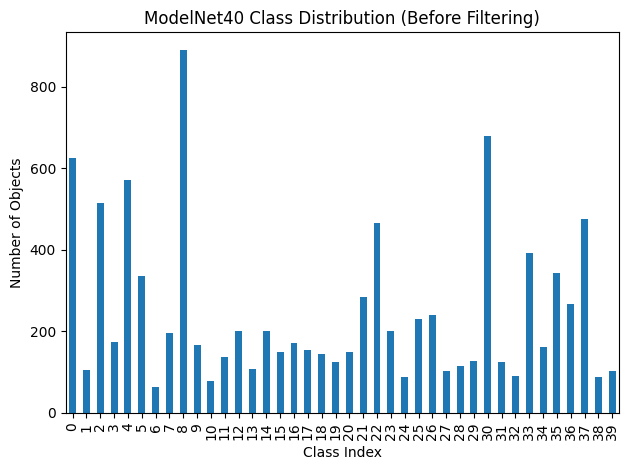

In [4]:
# 4) Distribution before filtering
counts_before = df['label'].value_counts().sort_index()
print("Object count per class (before):")
display(counts_before)

plt.figure()
counts_before.plot(kind='bar')
plt.xlabel('Class Index')
plt.ylabel('Number of Objects')
plt.title('ModelNet40 Class Distribution (Before Filtering)')
plt.tight_layout()
plt.show()


In [5]:
# %%
# 5) Filter out any object with fewer than 2048 points
min_pts = 2048
df_filtered = df[df['num_points'] >= min_pts].reset_index(drop=True)
print(f"Remaining objects after filtering (<{min_pts} pts removed): {len(df_filtered)}")


Remaining objects after filtering (<2048 pts removed): 6012


Object count per class (after):


label
0     622
1      68
2     301
3      79
4     199
5     214
6      26
7     196
8     647
9      12
10     29
11     89
12     92
13     43
14     90
15    106
16      6
17    144
18    135
19     80
20     70
21    265
22    208
23     74
24     82
25    198
26    189
27     75
28     93
29     92
30    429
31     72
32     43
33    156
34     59
35    261
36     95
37    261
38     26
39     86
Name: count, dtype: int64

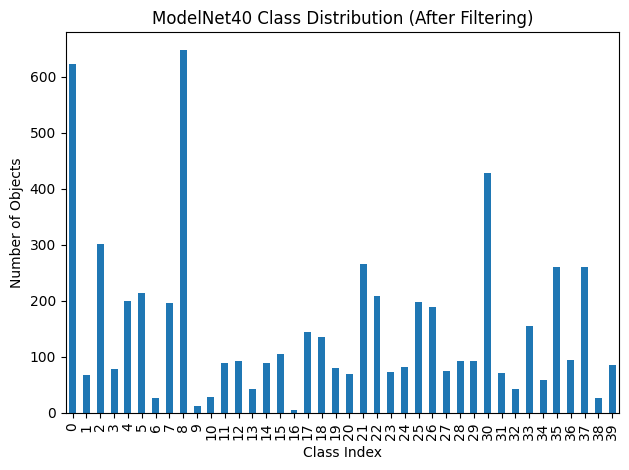

In [ ]:
# %%
# 6) Distribution after filtering
counts_after = df_filtered['label'].value_counts().sort_index()
print("Object count per class (after):")
display(counts_after)

plt.figure()
counts_after.plot(kind='bar')
plt.xlabel('Class Index')
plt.ylabel('Number of Objects')
plt.title('ModelNet40 Class Distribution (After Filtering)')
plt.tight_layout()
plt.show()


---

Loaded HDF5 with 51760 samples, each with 1024 points.
Instances per class:
- Class 0: 1294 samples
- Class 1: 1294 samples
- Class 2: 1294 samples
- Class 3: 1294 samples
- Class 4: 1294 samples
- Class 5: 1294 samples
- Class 6: 1294 samples
- Class 7: 1294 samples
- Class 8: 1294 samples
- Class 9: 1294 samples
- Class 10: 1294 samples
- Class 11: 1294 samples
- Class 12: 1294 samples
- Class 13: 1294 samples
- Class 14: 1294 samples
- Class 15: 1294 samples
- Class 16: 1294 samples
- Class 17: 1294 samples
- Class 18: 1294 samples
- Class 19: 1294 samples
- Class 20: 1294 samples
- Class 21: 1294 samples
- Class 22: 1294 samples
- Class 23: 1294 samples
- Class 24: 1294 samples
- Class 25: 1294 samples
- Class 26: 1294 samples
- Class 27: 1294 samples
- Class 28: 1294 samples
- Class 29: 1294 samples
- Class 30: 1294 samples
- Class 31: 1294 samples
- Class 32: 1294 samples
- Class 33: 1294 samples
- Class 34: 1294 samples
- Class 35: 1294 samples
- Class 36: 1294 samples
- Class 3

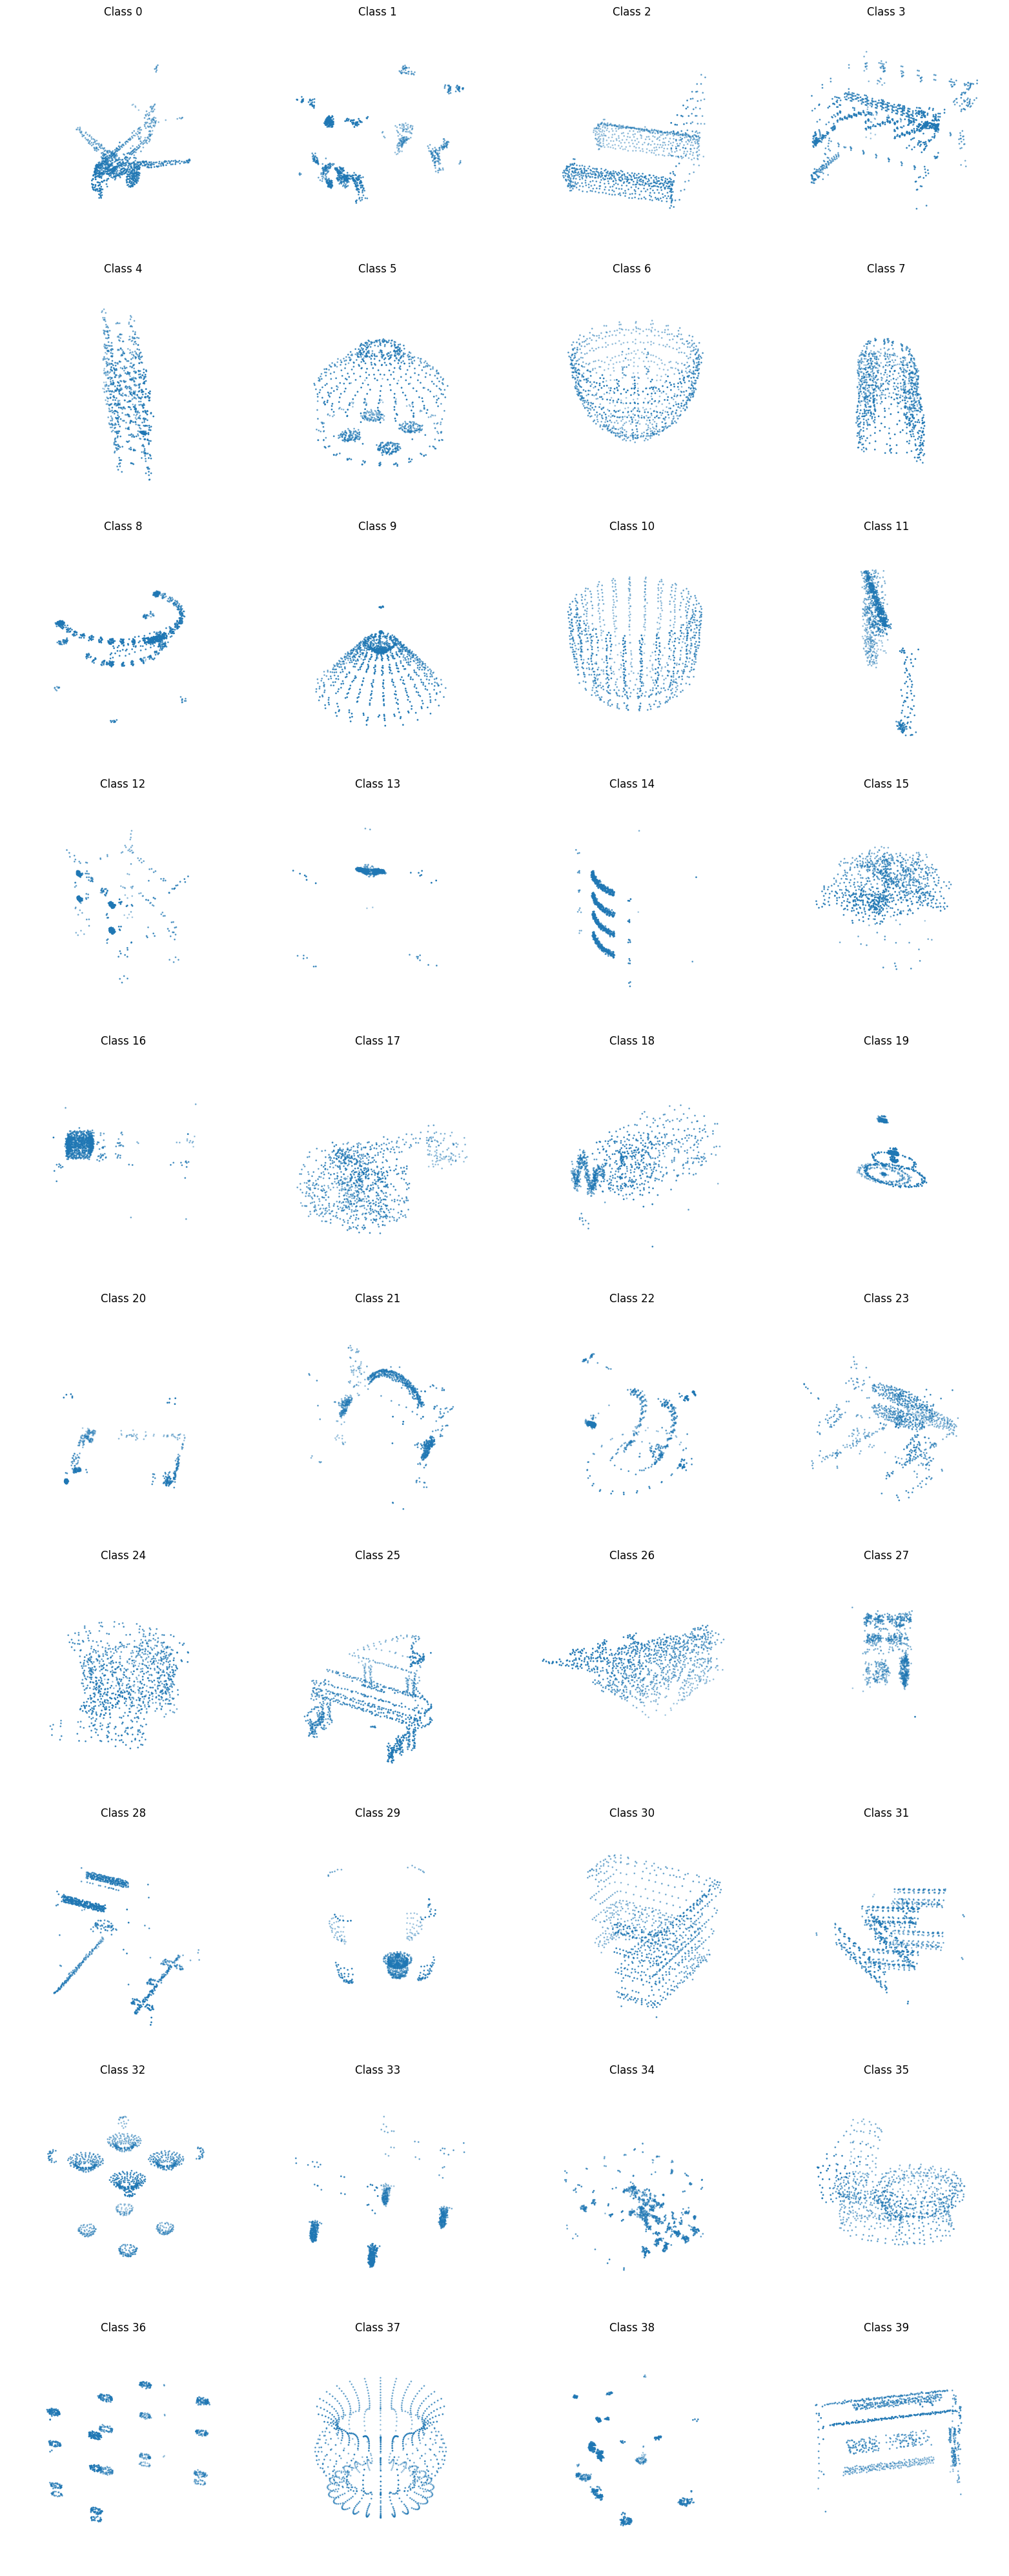

'\n## 5. Conclusions\n\n- The dataset is balanced by design: each class has the same number of samples.\n- You can adjust `h5_path` to point to different augmentation factors (×2, ×5, ×10, ×100).\n- The visualizations above confirm point clouds are centered and normalized.\n\n'

In [2]:
# %% [markdown]
"""
# ModelNet40 HDF5 Analysis Notebook

This notebook analyzes the HDF5 dataset created by augmenting ModelNet40 point clouds. It computes the number of instances per class and visualizes one random point cloud per class.
"""

# %% [markdown]
"""
## 1. Imports and Setup
"""
# %%
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# %% [markdown]
"""
## 2. Load the HDF5 Dataset

Adjust the path to match your dataset file.
"""
# %%
# Path to the HDF5 file (e.g., modelnet40_bal_x2.h5)
h5_path = './augmented_datasets/modelnet40_bal_x2.h5'

# Open the file and access datasets
hf = h5py.File(h5_path, 'r')
data = hf['data']      # shape: (N, num_points, 3)
labels = hf['label']   # shape: (N,)

print(f"Loaded HDF5 with {data.shape[0]} samples, each with {data.shape[1]} points.")

# %% [markdown]
"""
## 3. Compute Instances per Class

Count how many samples belong to each class label.
"""
# %%
unique_labels, counts = np.unique(labels[:], return_counts=True)
class_counts = dict(zip(unique_labels.tolist(), counts.tolist()))

print("Instances per class:")
for lbl, cnt in class_counts.items():
    print(f"- Class {lbl}: {cnt} samples")

# %% [markdown]
"""
## 4. Visualize a Random Instance per Class

Plot one randomly chosen point cloud for each class in a grid of 3D scatter plots.
"""
# %%
# Set up grid for plotting
n_classes = len(unique_labels)
cols = 4
rows = int(np.ceil(n_classes / cols))
fig = plt.figure(figsize=(4 * cols, 4 * rows))

for i, lbl in enumerate(unique_labels):
    ax = fig.add_subplot(rows, cols, i + 1, projection='3d')
    # Find indices for this class and select one randomly
    idxs = np.where(labels[:] == lbl)[0]
    rand_idx = np.random.choice(idxs)
    pc = data[rand_idx]  # (num_points, 3)
    ax.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=1)
    ax.set_title(f"Class {lbl}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# %% [markdown]
"""
## 5. Conclusions

- The dataset is balanced by design: each class has the same number of samples.
- You can adjust `h5_path` to point to different augmentation factors (×2, ×5, ×10, ×100).
- The visualizations above confirm point clouds are centered and normalized.

"""


In [22]:
# Display pytorch version
print("PyTorch version:", torch.__version__)

PyTorch version: 2.5.1+cu124
